# Processing ice thickness data

Adusumilli et al., (2020) provide ice thickness, altimetry-derived height and firn depth as anomalied with respect to the 2010-2018 mean. These values need to be corrected and represented from 2016-2018 as raw thickness change, raw height change, and raw firn column change.

Because ice thickness is calculated using both the height and firn column products, I need to make sure these are corrected into the raw change products first, before calculating ice thickness.

Importing packages

In [11]:
import os
import numpy as np
import rasterio as rio
from rasterio import transform
from rasterio.transform import from_origin
from rasterio.enums import Resampling
from rasterio.plot import show
from osgeo import gdal 
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from fnmatch import fnmatch
from rasterio.transform import Affine
from matplotlib_scalebar.scalebar import ScaleBar
import h5py

Here I define a function to write a numpy array to a GeoTiff

In [44]:
def writeNpToRaster(array, path, name, trans):
    r = rio.open(path + str(name) + '.tif', # save filepath for save
        'w', # 'write' mode
        driver = 'GTiff', # produces a .tif
        height = array.shape[0], # y len
        width = array.shape[1], # x len
        count = 1, # number of bands
        dtype = array.dtype, # get datatype from input array (float)
        crs = 'EPSG:3031', # polar crs
        transform = trans) # transform to projection of another rio DataReader object
    r.write(array,1)
    r.close()

Firstly, I set the directories and file lists to read in the height and firn anomalies: 

In [95]:
# altimetry height anomalies
heightAnomDir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_anoms')
heightAnomFiles = [file for file in heightAnomDir if fnmatch(file, '*.tif')]

# firn anomalies
firnAnomDir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_anoms')
firnAnomFiles = [file for file in firnAnomDir if fnmatch(file, '*.tif')]

Next, I loop through each of these files and compute, for each pixel, the height and firn column depth difference from the previous season.

In [ ]:
# dh height
dhpath = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/'
dhrawPath = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/'

transform = Affine(10000.00, 0.00,-2040000.00, 0.00,-10000.00, 820000.00)

arr = np.zeros(shape = (35,32))
for i in range(0, 12):
    
    print(f'\doing file: {heightAnomFiles[i]}')
    
    with rio.open(dhpath + dhfiles[i]) as src:
        
        data = src.read(1, masked = True)
        
        data = np.delete(data,32,1) # remove excess column
        
        data = np.delete(data,range(35,48),0) # remove lower rows
        
        change = data-arr # calculate raw change from anomaly differences
        
        name, ext = os.path.splitext(heightAnomfiles[i])
        
        writeNpToRaster(change, dhrawPath, name, transform)
        
        arr = data # set origin raster to current data

This writes to file a new raster of the computed height difference between **each** of the raster grids rather than to a decadal baseline.

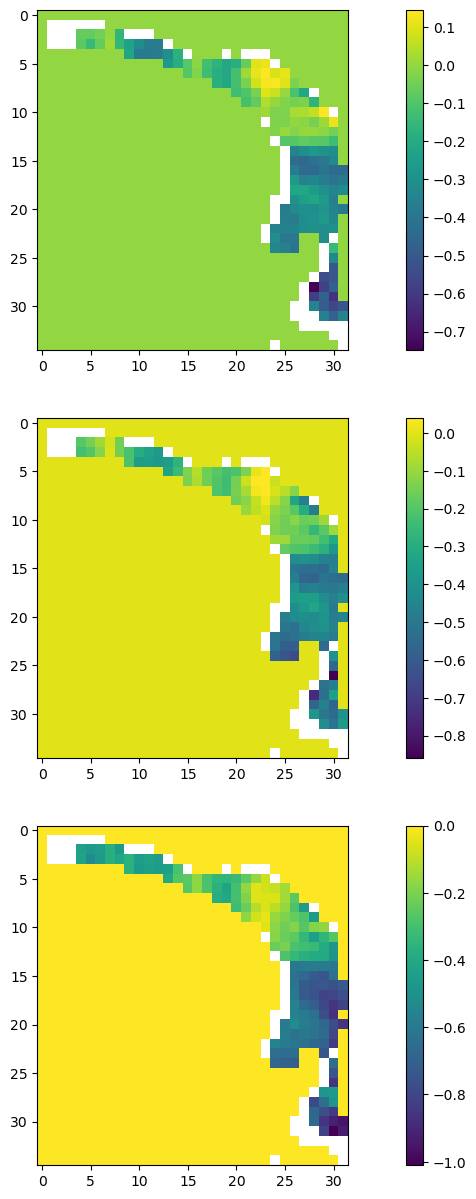

In [40]:
DJF2018 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/2018DJF_cropped.tif')
MAM2018 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/2018MAM_cropped.tif')
SON2018 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/2018SON_cropped.tif')

fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,15))
ax1.imshow(DJF2018.read(1), cmap='viridis')
hid = ax.imshow(DJF2018.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax1)
ax2.imshow(MAM2018.read(1), cmap='viridis')
hid = ax.imshow(MAM2018.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax2)
ax3.imshow(SON2018.read(1), cmap='viridis')
hid = ax.imshow(SON2018.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax3)

As we can see, this has worked, with the ice shelf height changing through the seasons. Now I repeat the process for firn depth.

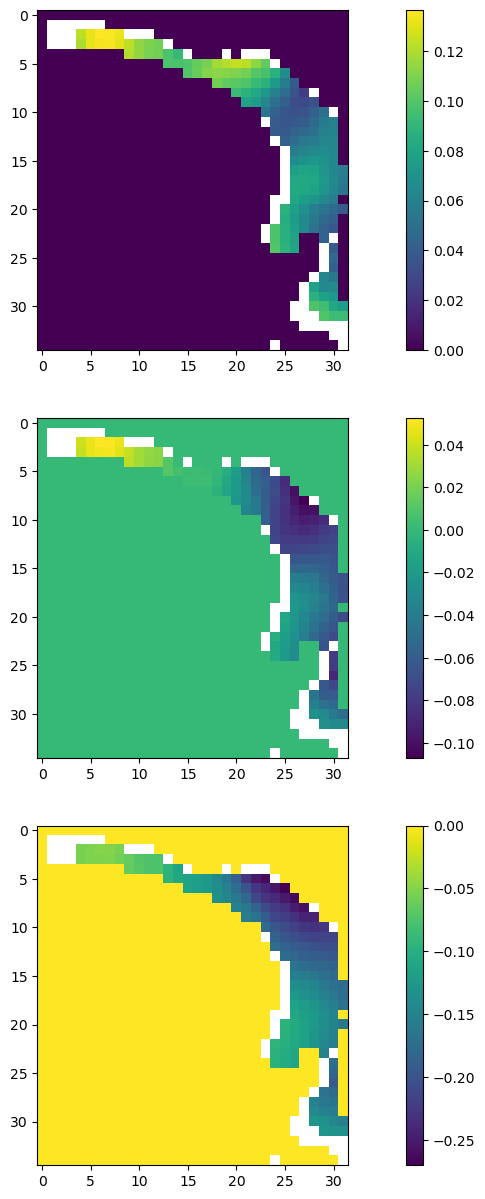

In [41]:
DJF2018 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/2018DJF_cropped.tif')
MAM2018 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/2018MAM_cropped.tif')
SON2018 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/2018SON_cropped.tif')

fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,15))
ax1.imshow(DJF2018.read(1), cmap='viridis')
hid = ax.imshow(DJF2018.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax1)
ax2.imshow(MAM2018.read(1), cmap='viridis')
hid = ax.imshow(MAM2018.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax2)
ax3.imshow(SON2018.read(1), cmap='viridis')
hid = ax.imshow(SON2018.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax3)

I now have raw changes in ice shelf height and firn depth across GeorgeVI. With this, I can now calculate the ice thickness based on hydrostatic equilibrium.

thickness change = (heightchange - firn_depth_change)*(1+rho_ice/(rho_ow - rho_ice))

Below I loop through the files and compute the raw ice thickness change for season.

In [83]:
dh_dir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw')
dh_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/'
air_dir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw')
air_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/'
dh_files = [file for file in dh_dir if fnmatch(file, '*.tif')]
air_files = [file for file in air_dir if fnmatch(file, '*.tif')]

output_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/thickness/thickness_raw/'

rho_ow = 1028 # density of ocean water
rho_ice = 917 # density of ice

for i in range(0,12): # 3 years' worth of seasons
    
    name,ext = os.path.splitext(dh_files[i]) # get filename
    
    print(f'Doing file {name}, {i+1} of 12')
    
    dh = dh_path + dh_files[i]
    
    air = air_path + air_files[i]
    
    with rio.open(dh) as dh_src, rio.open(air) as air_src:
        
        dh_data = dh_src.read(1)
        
        air_data = air_src.read(1)
        
    thickness = (dh_data - air_data)*(1+rho_ice/(rho_ow - rho_ice)) # calculate ice thickness change
    
    trans = Affine(10000.0, 0.0, -2040000.0,0.0, -10000.0, 820000.0)
    
    writeNpToRaster(thickness, output_path, name, trans)    

Doing file 2016MAM_cropped, 1 of 12
Doing file 2018MAM_cropped, 2 of 12
Doing file 2017MAM_cropped, 3 of 12
Doing file 2016SON_cropped, 4 of 12
Doing file 2016JJA_cropped, 5 of 12
Doing file 2018SON_cropped, 6 of 12
Doing file 2018JJA_cropped, 7 of 12
Doing file 2017JJA_cropped, 8 of 12
Doing file 2017SON_cropped, 9 of 12
Doing file 2016DJF_cropped, 10 of 12
Doing file 2018DJF_cropped, 11 of 12
Doing file 2017DJF_cropped, 12 of 12


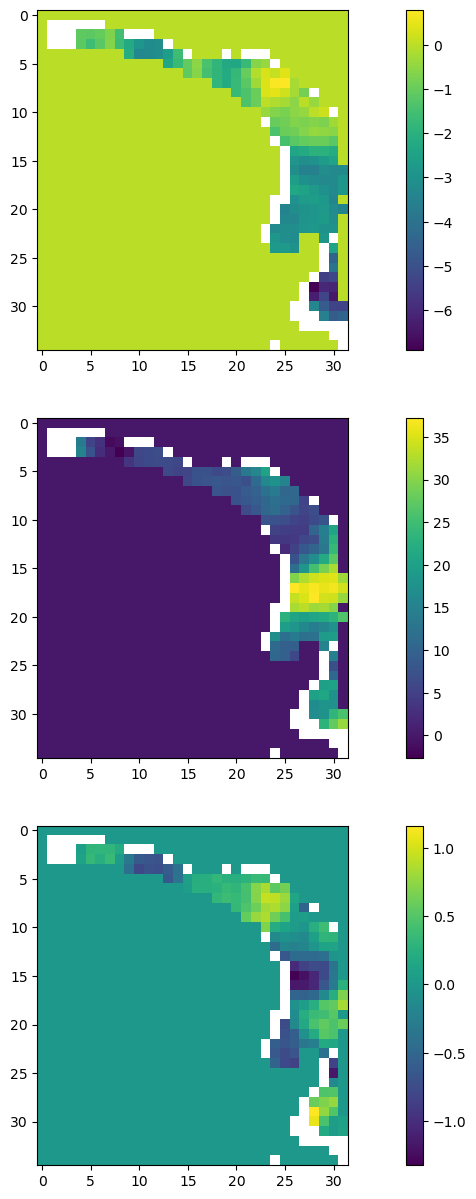

In [55]:
DJF2016 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/thickness/thickness_raw/2016DJF_cropped.tif')
MAM2016 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/thickness/thickness_raw/2016MAM_cropped.tif')
JJA2016 = rio.open('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/thickness/thickness_raw/2016JJA_cropped.tif')
fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,15))
ax1.imshow(DJF2016.read(1), cmap='viridis')
hid = ax.imshow(DJF2016.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax1)
ax2.imshow(MAM2016.read(1), cmap='viridis')
hid = ax.imshow(MAM2016.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax2)
ax3.imshow(JJA2016.read(1), cmap='viridis')
hid = ax.imshow(JJA2016.read(1), cmap='viridis')
plt.colorbar(hid, ax=ax3)

This is therefore the mean ice thickness change per season for George VI ice shelf.

But this might not be working. Why am I get such high thickness change values??
I am going to manually pick out a cell and apply the equation to see if I get the same result, which I should.

In [77]:
dh_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw/2016MAM_cropped.tif'
dair_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt/d_air_raw/2016MAM_cropped.tif'

with rio.open(dh_path) as dh, rio.open(dair_path) as dair:
    
    dh_r = dh.read(1)
    
    dair_r = dair.read(1)
    
    thickness = (dh_r[17,30]-dair_r[17,30])*(1+rho_ice/rho_ow-rho_ice)
    print(thickness)
    

4592.579651067549


4592 metres?? why on earth is that the calculated thickness? It's not even the same as what I've got for the looped value? What is going on?

I'm going to check this against the value that I got in the loop that I calculated

In [84]:
th_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/thickness/thickness_raw/2016MAM_cropped.tif'
with rio.open(th_path) as th:
    th_r = th.read(1)
    print(th_r[17,30])
    

-46.47875561878574


Minus 46 metres. Hmm. I wonder if something funny is happening with the raw height and air changes. Perhaps the large second value is deriving somehow from the first value.

I'm going to read in the height change anomalies for the first and second months

In [85]:
dh_anomDJF = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/2016DJF_cropped.tif'
dh_anomMAM = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/2016MAM_cropped.tif'

with rio.open(dh_anomDJF) as dhDJF, rio.open(dh_anomMAM) as dhMAM:
    djf_r = dhDJF.read(1)
    mam_r = dhMAM.read(1)
    
    print(djf_r[17,30])
    print(mam_r[17,30])

-4.79226526051904
-4.660804893638296


In [88]:
check = [-4, -4.001, -4.012, -3.98, -4.01]
arr = 0
for i in check:
    change = i-arr
    print(change)
    arr = i

-4
-0.001000000000000334
-0.010999999999999233
0.031999999999999584
-0.029999999999999805


So for value index 0, the change between that and zero is relatively large given the smaller changes afterwards. It doesn't make change to subtract zero from index zero because that isn't the raw height change. I need to track the changes **from** index 1 afterwards.

So below I rewrite my loop to compute the differences starting at index 1, not zero.

In [93]:
# altimetry height anomalies
heightAnomDir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt')
heightAnomFiles = [file for file in heightAnomDir if fnmatch(file, '*.tif')]

# firn anomalies
firnAnomDir = os.listdir('/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dair_dt')
firnAnomFiles = [file for file in firnAnomDir if fnmatch(file, '*.tif')]

In [94]:
# dh height
dh_anom_path = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/'
dhrawPath = '/Users/louie.bell/Cambridge/mphil/Essay (Practical) 3/data/basal melt/dh_dt/dh_raw_corr/'

transform = Affine(10000.00, 0.00,-2040000.00, 0.00,-10000.00, 820000.00)

for i in range(1, 12): # starting at index 1 NOT ZERO
    
    print(f'\doing file: {heightAnomFiles[i]}')
    
    with rio.open(dh_anom_path + heightAnomFiles[i]) as src1, rio.open(dh_anom_path + heightAnomFiles[i-1]) as src_0:
        
        data = src.read(1, masked = True)
        
        data = np.delete(data,32,1) # remove excess column
        data = np.delete(data,range(35,48),0) # remove lower rows
        
        data0 = src0.read(1, masked = True)
        
        data0 = np.delete(data0,32,1) # remove excess column
        data0 = np.delete(data0,range(35,48),0) # remove lower rows
        
        change = data-data0 # calculate raw height change from anomaly differences
        
        name, ext = os.path.splitext(heightAnomFiles[i])
        
        writeNpToRaster(change, dhrawPath, name, transform)

\doing file: 2017MAM_cropped.tif


NameError: name 'heightAnomfiles' is not defined

In [89]:
list(range(1,12))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]